# 1. Import some netCDF data with xarray, plot with hvPlot, and export with Panel

In [1]:
import hvplot.xarray
import panel as pn
import xarray as xr

In [2]:
# Load data
temperature = xr.open_dataset("toydata_era5.nc").tas.groupby("time.season").mean()

# Most web plot things prefer [-180, 180] over [0-360]
temperature = temperature.assign_coords(lon=(temperature.lon + 180) % 360 - 180).sortby(
    "lon"
)

# Preview the data
temperature.head(3)

<xarray.DataArray 'tas' (season: 3, lat: 3, lon: 3)>
array([[[242.5923 , 242.5923 , 242.5923 ],
        [242.21167, 242.21326, 242.21475],
        [241.89642, 241.89943, 241.90251]],

       [[221.0026 , 221.0026 , 221.0026 ],
        [220.36366, 220.36511, 220.36665],
        [220.02242, 220.02545, 220.02838]],

       [[222.75087, 222.75087, 222.75087],
        [222.33438, 222.3363 , 222.33827],
        [222.2462 , 222.25002, 222.2539 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5
  * lon      (lon) float64 -180.0 -179.8 -179.5
    height   float64 ...
  * season   (season) object 'DJF' 'JJA' 'MAM'

In [3]:
# Plot the data
visualization = temperature.hvplot.image(
    "lon",
    "lat",
    cmap="coolwarm",
    geo=True,
    global_extent=True,
    frame_width=500,
    frame_height=500,
    tiles="StamenToner",
    alpha=0.9,
    rasterize=True,
    project=True,
    widget_location="right_top",
)

# Show the visualization
visualization

Row
    [0] HoloViews(DynamicMap)
    [1] Column
        [0] WidgetBox
            [0] Select(margin=(20, 20, 20, 20), name='season', options=['DJF', 'JJA', ...], value='DJF', width=250)
        [1] VSpacer()

In [4]:
# Add a header to the 'app'
app = pn.Column(
    "# Cool interactive image plot created with xarray, hvplot, and panel",
    visualization,
)

# Save it
app.save("../static/hvplot_image.html", embed=True, progress=False)

In [5]:
# Alternatively, to store the states in separate JSON files:
# app.save(
#     "../static/hvplot_image.html",
#     embed=True,
#     embed_json=True,
#     save_path="../static",
#     load_path="./",
#     json_prefix="hvplot_image_data",
#     progress=False,
# )

# 2. Read some netCDF data with xarray, calculate colors, export as JSON for plotting with deck.gl

In [6]:
import matplotlib.pyplot as plt
import xarray as xr

In [7]:
# Load data
temperature = xr.open_dataset("toydata_era5.nc").tas.groupby("time.season").mean()

# Most web plot things prefer [-180, 180] over [0-360]
temperature = temperature.assign_coords(lon=(temperature.lon + 180) % 360 - 180).sortby(
    "lon"
)

# Preview the data
temperature.head(3)

<xarray.DataArray 'tas' (season: 3, lat: 3, lon: 3)>
array([[[242.5923 , 242.5923 , 242.5923 ],
        [242.21167, 242.21326, 242.21475],
        [241.89642, 241.89943, 241.90251]],

       [[221.0026 , 221.0026 , 221.0026 ],
        [220.36366, 220.36511, 220.36665],
        [220.02242, 220.02545, 220.02838]],

       [[222.75087, 222.75087, 222.75087],
        [222.33438, 222.3363 , 222.33827],
        [222.2462 , 222.25002, 222.2539 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5
  * lon      (lon) float64 -180.0 -179.8 -179.5
    height   float64 ...
  * season   (season) object 'DJF' 'JJA' 'MAM'

In [8]:
# Convert to tabular data
df = (
    temperature.sel(season="DJF")
    .where((temperature.lat > -90) & (temperature.lat < 90))
    .where(  # smaller extent to limit output file size
        (-25 < temperature.lon)
        & (temperature.lon < 50)
        & (temperature.lat > 20)
        & (temperature.lat < 70)
    )
    .drop(["height", "season"], axis=1)
    .to_dataframe()
    .reset_index()
    .dropna()
)

# Determine colors
norm = lambda array: (array - array.min()) / (array.max() - array.min())
df["color"] = plt.cm.coolwarm(norm(df.tas), bytes=True)[:, :3].tolist()
df = df.drop("tas", axis=1)

# Store as json file
df.to_json("../static/era5_data_cutout.json", orient="records")

# Show what it looks like
df.head()

lat    lon          color
635661  20.25 -24.75  [211, 77, 64]
635662  20.25 -24.50  [211, 77, 64]
635663  20.25 -24.25  [211, 77, 64]
635664  20.25 -24.00  [211, 77, 64]
635665  20.25 -23.75  [212, 79, 66]

# 3. Creating an image with Datashader

In [9]:
import datashader
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import xarray as xr
from PIL.Image import fromarray

In [10]:
# Load data and get mean winter temperature
temperature = (
    xr.open_dataset("toydata_era5.nc")
    .tas.groupby("time.season")
    .mean()
    .sel(season="DJF")
)

# Prefer [-180, 180] over [0-360]
temperature["lon"] = (temperature.lon + 180) % 360 - 180
temperature = temperature.sortby("lon")

# Preview the data
temperature.head(3)

<xarray.DataArray 'tas' (lat: 3, lon: 3)>
array([[242.5923 , 242.5923 , 242.5923 ],
       [242.21167, 242.21326, 242.21475],
       [241.89642, 241.89943, 241.90251]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5
  * lon      (lon) float64 -180.0 -179.8 -179.5
    height   float64 ...
    season   <U3 'DJF'

In [11]:
# Reproject the coordinates to the Mercator projection (from EPSG:4326 to EPSG:3857):
temperature = temperature.where(np.abs(temperature.lat) < 85.06, drop=True)
proj = pyproj.Transformer.from_crs(4326, 3857, always_xy=True)
x = proj.transform(temperature.lon, np.zeros(len(temperature.lon)))[0]
y = proj.transform(np.zeros(len(temperature.lat)), temperature.lat)[1]
temperature = temperature.assign_coords(lon=x, lat=y)

# Preview new coords
temperature.head(3)

<xarray.DataArray 'tas' (lat: 3, lon: 3)>
array([[251.9484 , 252.12877, 252.39397],
       [257.35596, 257.27295, 257.18793],
       [262.61325, 262.5325 , 262.44968]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -1.997e+07 -1.966e+07 -1.936e+07
  * lon      (lon) float64 -2.004e+07 -2.001e+07 -1.998e+07
    height   float64 2.0
    season   <U3 'DJF'

In [12]:
# Aggregate the data onto a fixed canvas (with exactly 1 pixel per grid cell)
cvs = datashader.Canvas(plot_width=1440, plot_height=681)
agg = cvs.quadmesh(
    temperature, x="lon", y="lat"
)  # can't use raster for mercator is irregular!

In [13]:
# Convert aggregated data to image array
out = datashader.transfer_functions.shade(agg, cmap=plt.cm.coolwarm)

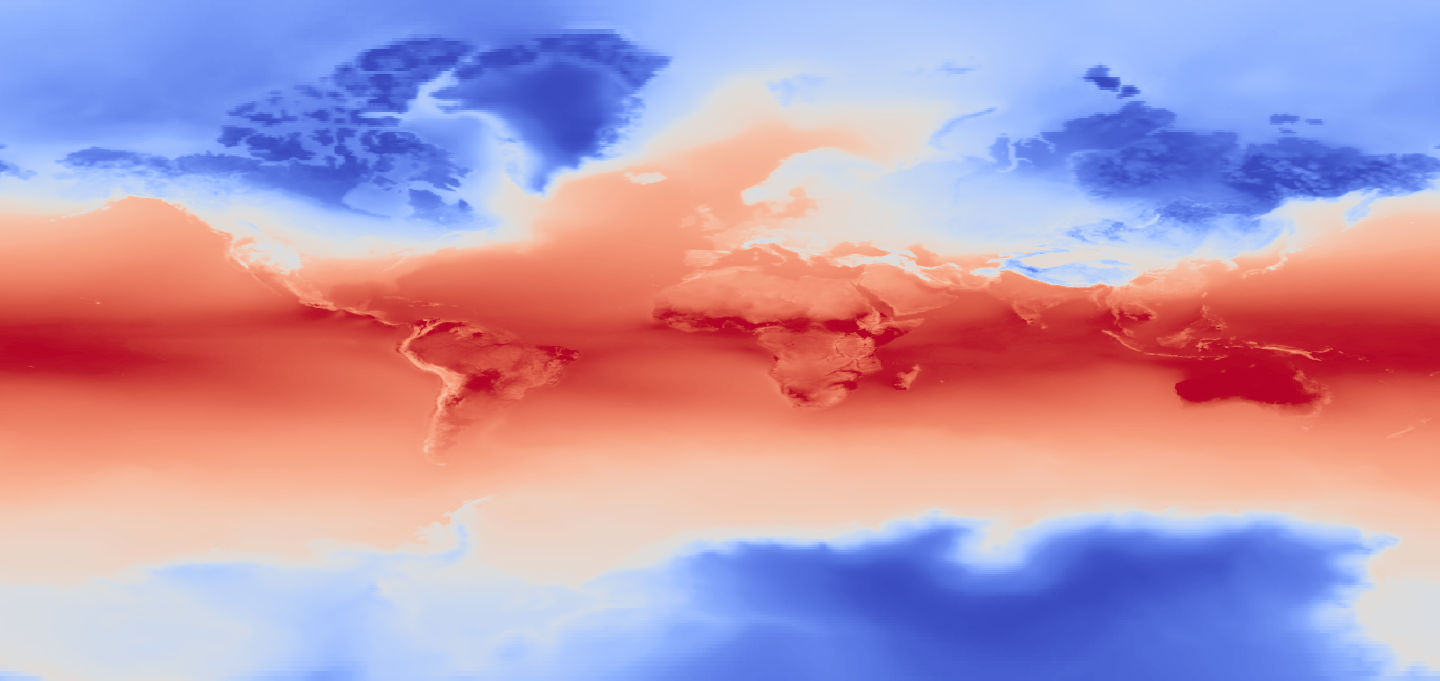

In [14]:
# Parse image array as image so we can store it
img = fromarray(
    np.flip(out.data, 0), "RGBA"
)  # flip since y tiles go down (Google map tiles)

# Store
img.save("../static/era5_image.png")

# Preview
img

# 4. Creating tiles with Datashader

Adapted from https://nbviewer.jupyter.org/github/brendancol/datashader/blob/43cb3a913ce87fa9f2442d4ceba471e82b17962f/examples/tiling.ipynb

In [15]:
import datashader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
import xarray as xr
from datashader.tiles import render_tiles

In [16]:
def load_data_func(x_range, y_range):
    global df
    if df is None:
        da = (
            xr.open_dataset("toydata_era5.nc")
            .tas.groupby("time.season")
            .mean()
            .sel(season="DJF")
        )

        # lat/lon to mercator
        da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180)).where(
            np.abs(da.lat) < 85.06, drop=True
        )
        proj = pyproj.Transformer.from_crs(4326, 3857, always_xy=True)
        x = proj.transform(da.lon, np.zeros(len(da.lon)))[0]
        y = proj.transform(np.zeros(len(da.lat)), da.lat)[1]
        da = da.assign_coords(lon=x, lat=y).rename({"lon": "x", "lat": "y"})

        #         print(
        #             "bounds:",
        #             temperature.lat.values.min(),
        #             temperature.lat.values.max(),
        #             temperature.lon.values.min(),
        #             temperature.lon.values.max(),
        #         )

        # To dataframe
        df = da.to_dataframe().reset_index()

    return df.loc[df["x"].between(*x_range) & df["y"].between(*y_range)]


def rasterize_func(df, x_range, y_range, height, width):
    """Use quadmesh for mercator projection is irregular!"""
    # aggregate
    cvs = datashader.Canvas(
        x_range=x_range, y_range=y_range, plot_height=height, plot_width=width
    )
    da = df.set_index(["y", "x"]).to_xarray().tas
    agg = cvs.quadmesh(da, x="x", y="y")
    return agg


def shader_func(agg, span=None):
    return datashader.transfer_functions.shade(
        agg, cmap=plt.cm.coolwarm, span=span, how="log"
    )


def post_render_func(img, **kwargs):
    return img

In [17]:
df = None

# Found out by printing xmin, xmax etc after transforming to web mercator.
full_extent_of_data = (
    -19971868.88040857,
    -20037508.342789244,
    19971868.880408563,
    20009678.470090926,
)

output_path = "../static/era5_tiles"
results = render_tiles(
    full_extent_of_data,
    range(6),  # At level 6 it performance starts degrading significantly.
    load_data_func=load_data_func,
    rasterize_func=rasterize_func,
    shader_func=shader_func,
    post_render_func=post_render_func,
    output_path=output_path,
)

calculating statistics for level 0
rendering 1 supertiles for zoom level 0 with span=(233.9702941894531, 308.1686543782552)
calculating statistics for level 1
rendering 1 supertiles for zoom level 1 with span=(232.83126831054688, 308.4970296223958)
calculating statistics for level 2
rendering 1 supertiles for zoom level 2 with span=(231.95306396484375, 308.85992431640625)
calculating statistics for level 3
rendering 1 supertiles for zoom level 3 with span=(231.95306396484375, 308.94384765625)
calculating statistics for level 4
rendering 1 supertiles for zoom level 4 with span=(231.95306396484375, 308.94384765625)
calculating statistics for level 5
rendering 4 supertiles for zoom level 5 with span=(231.95306396484375, 308.94384765625)


# Bonus: using geopandas/geojson

In [18]:
import geopandas as gpd
import numpy as np
import shapely

In [19]:
# Load data and get mean winter temperature
temperature = (
    xr.open_dataset("toydata_era5.nc")
    .tas.groupby("time.season")
    .mean()
    .sel(season="DJF")
)

# Prefer [-180, 180] over [0-360]
temperature["lon"] = (temperature.lon + 180) % 360 - 180
temperature = temperature.sortby("lon")

# Preview the data
temperature.head(3)

<xarray.DataArray 'tas' (lat: 3, lon: 3)>
array([[242.5923 , 242.5923 , 242.5923 ],
       [242.21167, 242.21326, 242.21475],
       [241.89642, 241.89943, 241.90251]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5
  * lon      (lon) float64 -180.0 -179.8 -179.5
    height   float64 ...
    season   <U3 'DJF'

In [20]:
# Convert to tabular format
df = (
    temperature.where(
        (-25 < temperature.lon)
        & (temperature.lon < 50)
        & (temperature.lat > 20)
        & (temperature.lat < 70)
    )
    .drop(["height", "season"], axis=1)
    .to_dataframe()
    .reset_index()
    .dropna()
)
df.head()

lat    lon         tas
635661  20.25 -24.75  294.241577
635662  20.25 -24.50  294.205292
635663  20.25 -24.25  294.161774
635664  20.25 -24.00  294.120148
635665  20.25 -23.75  294.087463

tas                    geometry
635661  294.241577  POINT (-24.75000 20.25000)
635662  294.205292  POINT (-24.50000 20.25000)
635663  294.161774  POINT (-24.25000 20.25000)
635664  294.120148  POINT (-24.00000 20.25000)
635665  294.087463  POINT (-23.75000 20.25000)

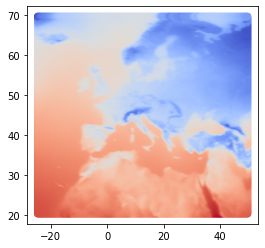

In [21]:
# Add geometry as points
gdf = gpd.GeoDataFrame(
    df.tas, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326"
)
gdf.plot(column="tas", cmap="coolwarm")
gdf.head()

In [22]:
# Add geometry as polygons (much slower than points)


@np.vectorize
def point_to_bbox(x, y, dx, dy):
    return shapely.geometry.box(x - dx / 2, y - dy / 2, x + dx / 2, y + dy / 2)


def normalize(array):
    return (array - array.min()) / (array.max() - array.min())


gdf = gpd.GeoDataFrame(
    df.tas, geometry=point_to_bbox(df.lon, df.lat, 0.25, 0.25), crs="EPSG:4326"
)

gdf[["r", "g", "b"]] = plt.cm.coolwarm(normalize(gdf.tas), bytes=True)[:, :3]
gdf.plot(column="tas", cmap="coolwarm")
gdf = gdf.drop("tas", axis=1)
gdf.to_file("../static/era5_data_cutout.geojson", driver="GeoJSON")
gdf.head()

geometry    r   g   b
635661  POLYGON ((-24.62500 20.12500, -24.62500 20.375...  211  77  64
635662  POLYGON ((-24.37500 20.12500, -24.37500 20.375...  211  77  64
635663  POLYGON ((-24.12500 20.12500, -24.12500 20.375...  211  77  64
635664  POLYGON ((-23.87500 20.12500, -23.87500 20.375...  211  77  64
635665  POLYGON ((-23.62500 20.12500, -23.62500 20.375...  212  79  66